In [3]:
import os
import numpy as np
from osgeo import gdal
# from osgeo import gdal_array
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt

In [6]:
print(2./3.)

0.6666666666666666


In [7]:
def normalized_uint8( a, nan_val = 0 ):
    amin = np.nanmin(a)
    amax = np.nanmax(a)
    a_shape = np.shape(a)
    ar = np.ravel(a)
    ar[np.where(np.isnan)] = nan_val
    ar = np.round(255*(ar-amin)/(amax-amin))
    return np.reshape(ar,a_shape).astype('uint8')


def veg_func(r, g, b, name='GRRI', nan_val=0):
    '''
    Excess Red (ExR)
        Meyer, G. E., Hindman, T. W., and Laksmi, K. (1999). Machine vision
        detection parameters for plant species identification. in, eds.
        G. E. Meyer and J. A. DeShazer (Boston, MA), 327â€“335.
        doi:10.1117/12.336896.
    Excess Green (ExG)
        Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A.
        1995. Color Indices forWeed Identification Under Various Soil,
        Residue, and Lighting Conditions. Trans. ASAE, 38, 259-269.
    Excess Green minus R (ExGR)
        Neto, J.C. 2004. A combined statistical-soft computing approach
        for classification and mapping weed species in minimum -tillage
        systems. Ph.D. Thesis, University of Nebraska, Lincoln, Lincoln,
        NE, USA, August 2004.
        
    Thanks to Phil Wernette, USGS
    '''
    a_shape = np.shape(r)
    if name == 'GRRI':
        a = g / r
    elif name == 'ExR':
        a = 1.4*b - g
    elif name == 'ExG':
        a = 2.*g-r -b
    elif name == 'ExGR':
        a = (2.*g-r-b) - (1.4*b - g)   
    else:
        a = a*np.nan
        print('Bad vlaue for name in veg_func')

    amin = np.nanmin(a)
    amax = np.nanmax(a)
    ar = np.ravel(a)
    ar[np.where(np.isnan)] = nan_val
    ar = np.round(255*(ar-amin)/(amax-amin))
    return np.reshape(ar,a_shape).astype('uint8')

def twod_stats(im):
    print('dtype:', im.dtype, 'shape', im.shape)
    print('Number of nans:',np.sum(np.isnan(np.ravel(im))))
    print('2.5% {}, 97.5% {}'.format(np.nanpercentile(im, 2.5), np.nanpercentile(im, 97.5)))
    print('1% {}, 99% {}'.format(np.nanpercentile(im, 1), np.nanpercentile(im, 99)))
    print('min {}, max {}'.format(np.nanmin(im), np.nanmax(im)))
    print('median {}, mean {}'.format(np.nanpercentile(im, 50), np.nanmean(im)))

In [9]:
drive = 'D:'
big_ortho_dir = drive+'/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog'
big_ortho_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif'

big_dem_dir = drive+'/crs/proj/2021_FloSupp_Release/Clipped_Final/'
big_dem_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif'

work_dir = drive+'/crs/proj/2022_NOPP/Composite_Experiment'
gm_dir = '/gm'
dem_dir = '/dem'
slope_dir = '/slope'
ortho_dir = '/ortho'
grayscale_dir = '/grayscale'
   
#gdal_calc.py -R input.tif --R_band=1 -G input.tif --G_band=2 -B input.tif --B_band=3 --outfile=result.tif --calc="R*0.2989+G*0.5870+B*0.1140"

In [10]:
# Make sure working folder exists
try:
    os.makedirs(work_dir)
except FileExistsError:
    # directory already exists
    print(work_dir,' exists.')

D:/crs/proj/2022_NOPP/Composite_Experiment  exists.


### Establish bounding box for the site

In [12]:
# define a box
ulx=392750.
uly=3873000.
boxx = 3800.
boxy = 2500.

urx=ulx+boxx
lrx=ulx+boxx
llx=ulx

ury=uly
lry=uly-boxy
lly=uly-boxy

# make sure GlobalMapper folder exists
out_dir = work_dir+gm_dir
try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

# write corners of the box into a .csv file
corners_file = '/bbox_corners.csv'
f = open(out_dir+corners_file, 'w')
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.write('{:.1f},{:.1f}\n'.format(urx,ury))
f.write('{:.1f},{:.1f}\n'.format(lrx,lry))
f.write('{:.1f},{:.1f}\n'.format(llx,lly))
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.close()
print('Wrote', out_dir+corners_file)

D:/crs/proj/2022_NOPP/Composite_Experiment/gm exists.
Wrote D:/crs/proj/2022_NOPP/Composite_Experiment/gm/bbox_corners.csv


### Cut out the DEM for that site
...and make grid finer, from 1 m to 0.25 m


In [13]:
in_file = big_dem_dir+big_dem_fname
out_dir = work_dir+dem_dir
dem_file = '/dem25_nearest.jpg'
out_file = out_dir+dem_file

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -tr 0.25 0.25 -r nearest -of JPEG  {} {}'.format(
    ulx, uly, lrx, lry, in_file, out_file)
print(gdal_cmd)

if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

D:/crs/proj/2022_NOPP/Composite_Experiment/dem exists.
gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -tr 0.25 0.25 -r nearest -of JPEG  D:/crs/proj/2021_FloSupp_Release/Clipped_Final//20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif D:/crs/proj/2022_NOPP/Composite_Experiment/dem/dem25_nearest.jpg
Success


#### do it again, but with cubic spline interpolation (much slower)

In [14]:
dem_file = '/dem25_cubic.jpg'
out_file = out_dir+dem_file
gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -tr 0.25 0.25 -r cubicspline -of JPEG  {} {}'.format(
    ulx, uly, lrx, lry, in_file, out_file)
print(gdal_cmd)

if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -tr 0.25 0.25 -r cubicspline -of JPEG  D:/crs/proj/2021_FloSupp_Release/Clipped_Final//20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif D:/crs/proj/2022_NOPP/Composite_Experiment/dem/dem25_cubic.jpg
Success


### Cut out the ortho for that site
Keep as a geotiff for now.

In [15]:
infile = big_ortho_dir+big_ortho_fname
out_dir = work_dir+ortho_dir
ortho_file = '/ortho.tif'
out_file = out_dir+ortho_file

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -b 2 -b 3 -of GTiff {} {}'.format(ulx, uly, lrx, lry, infile, out_file)
print(gdal_cmd)
if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

D:/crs/proj/2022_NOPP/Composite_Experiment/ortho exists.
gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -b 2 -b 3 -of GTiff D:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif D:/crs/proj/2022_NOPP/Composite_Experiment/ortho/ortho.tif
Success


### Read in the ortho for other calcs using rioxarray

In [16]:
in_file = work_dir+ortho_dir+ortho_file
ds_ortho = rio.open_rasterio(in_file)
ds_ortho

<xarray.DataArray (band: 3, y: 10000, x: 15200)>
[456000000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 3.928e+05 3.928e+05 ... 3.965e+05 3.965e+05
  * y            (y) float64 3.873e+06 3.873e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [17]:
# pull bands out as arrays
r = np.array(ds_ortho[0].values)
g = np.array(ds_ortho[1].values)
b = np.array(ds_ortho[2].values)

### Make a grayscale ortho

(array([9.994000e+03, 1.419910e+05, 3.949590e+05, 9.096720e+05,
        2.327239e+06, 4.892883e+06, 6.661860e+06, 7.354754e+06,
        7.257822e+06, 6.136098e+06, 4.699273e+06, 3.543763e+06,
        2.575930e+06, 2.063523e+06, 1.830671e+06, 1.680294e+06,
        1.336190e+06, 9.838220e+05, 4.726700e+05, 1.427410e+05,
        5.959600e+04, 1.766700e+04, 6.580000e+03, 6.506000e+03,
        2.220000e+03]),
 array([ 12.  ,  20.96,  29.92,  38.88,  47.84,  56.8 ,  65.76,  74.72,
         83.68,  92.64, 101.6 , 110.56, 119.52, 128.48, 137.44, 146.4 ,
        155.36, 164.32, 173.28, 182.24, 191.2 , 200.16, 209.12, 218.08,
        227.04, 236.  ]),
 <BarContainer object of 25 artists>)

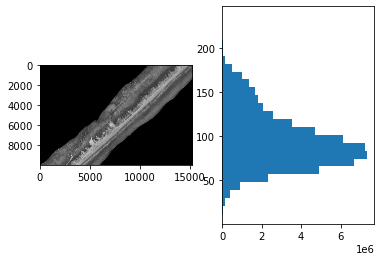

In [29]:
gray = np.round((0.2989*r + 0.5870*g + 0.1140*b)).astype('uint8')
ax1=plt.subplot(1,2,1)
ax1.imshow(gray, cmap='gray')
ax2=plt.subplot(1,2,2)
data = np.ravel(gray)
data = data[np.where(data>0)]
ax2.hist(data, bins=25, orientation="horizontal")

### Make three different veg indices

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_15400\1074220327.py:32: RuntimeWarning: invalid value encountered in true_divide
  a = g / r


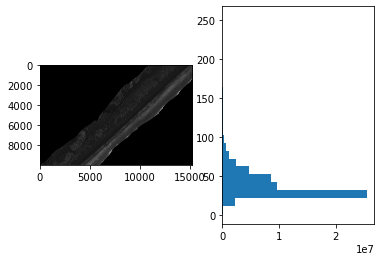

In [34]:
GRRI = veg_func(r, g, b, name='GRRI', nan_val=0)

ax1=plt.subplot(1,2,1)
ax1.imshow(GRRI, cmap='gray')
ax2=plt.subplot(1,2,2)
data = np.ravel(GRRI)
data = data[np.where(data>0)]
_ = ax2.hist(data, bins=25, orientation="horizontal")

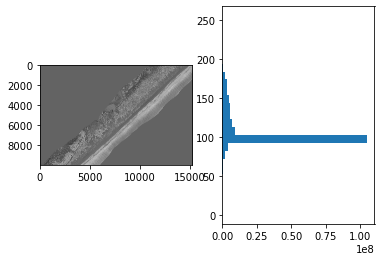

In [31]:
ExG = veg_func(r, g, b, name='ExG', nan_val=0)

ax1=plt.subplot(1,2,1)
ax1.imshow(ExG, cmap='gray')
ax2=plt.subplot(1,2,2)
data = np.ravel(ExG)
data = data[np.where(data>0)]
_ = ax2.hist(data, bins=25, orientation="horizontal")

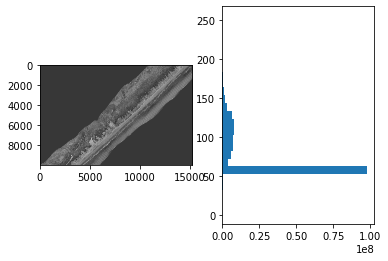

In [32]:
ExR = veg_func(r, g, b, name='ExR', nan_val=0)
ax1=plt.subplot(1,2,1)
ax1.imshow(ExR, cmap='gray')
ax2=plt.subplot(1,2,2)
data = np.ravel(ExR)
data = data[np.where(data>0)]
_ = ax2.hist(data, bins=25, orientation="horizontal")